# **Position Reconstruction using PMTs waveforms from CYGNO LIME 2 detector**

* The idea of this project came from a laboratory activity done in Laboratori Nazionali di Frascati, based on the CYGNO experiment for Directional Dark Matter search.
* The main goal is to study the behaviour and efficiency of two possible Neural Network architectures able to analyze the waveforms extracted from 4 PMTs, positioned at the corners of a squared-based cone, when a particle crosses the detector.
* A possible application of such a Neural Network is the 3D reconstruction of the particle's track, if combined with the images from the LIME Time Projection Chamber. Neveretheless, this part will not be covered in this project, since it would require appropriate data analysis from the underground facility in Laboratori Nazionali del Gran Sasso.
* The network study is expanded with a **toy model simulation**, and the results are presented as squared **RMSE-colormaps** which are able to provide at glance the network's predictions precision over the scanned regions.

The dataset used to train the networks can be found on [Google Drive](https://drive.google.com/drive/folders/1-3Ghqj2Ps7Avec3rxHVLbOZatDtLko-8?usp=sharing), along with a .csv file used to keep track of the target positions scanned in the various runs. \\
Moreover, a folder containg some relevant pre-trained models can be found at the same link.
In order for the code to work, **please add a shortcut to this folder on your main GDrive folder**.

```
Code by Luca Zappaterra, last modified: 11/07/2022
```



# WandB installs, imports and login

[Weights and Biases](https://wandb.ai/) is a powerful tool to keep track of ML/DL projects, but to run the code with `LOG_TO_WANDB=True` it is required to create an account. \\
To run this code with no W&B log, just switch to `LOG_TO_WANDB=False` in the last cell of this section.

In [ ]:
# install wandb and fastprogress to implement a fancy progressbar
!pip install fastprogress -Uqqq
!pip install wandb --upgrade -Uqqq

# also install torchinfo and torchviz, just in case
!pip install torchinfo -q
!pip install torchviz -q

from IPython.display import display, clear_output
clear_output()

In [ ]:
# import useful modules
import os
import PIL
import time
import copy
import torch
import numpy as np
import pandas as pd
from os import listdir
from os.path import isfile, join
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from fastprogress.fastprogress import master_bar, progress_bar
from datetime import datetime
import matplotlib.pyplot as plt


# set custom params for plots
plt.rcParams['figure.titlesize'] = 18
plt.rcParams['axes.grid'] = True
plt.rcParams['grid.alpha'] = .5
plt.rcParams['grid.linestyle'] = '--'
plt.rcParams['figure.figsize'] = 12, 7
plt.rcParams['figure.dpi'] = 200
plt.rcParams['figure.subplot.wspace'] = 0.2
plt.rcParams['figure.subplot.hspace'] = 0.4

In [ ]:
import wandb

LOG_TO_WANDB = False

if LOG_TO_WANDB: wandb.login()

# CYGNO-related stuff

**This is really crucial!** The dataset is encoded in a particular format which is managed by the `midas` module. \\
Moreover, some useful pre-built access function are provided in the [`cygno`](https://github.com/CYGNUS-RD/cygno) module, maintained by the LNF and LNGS researchers.

In [ ]:
# CYGNO lib and dependencies installs
!pip install 'https://github.com/CYGNUS-RD/middleware/blob/master/midas/midaslib.tar.gz?raw=t!rue' -q
!pip install -U git+https://git@github.com/dodas-ts/boto3sts -q
!pip install git+https://github.com/CYGNUS-RD/cygno.git -U -q

clear_output()

In [ ]:
# import cygno libs
import midas.file_reader
import cygno as cy

# Enviroment settings

This notebook is thought to run on Colab, Sagemaker and on the INFN-Cloud, so switching from `notebook_is_onColab = True` and `notebook_is_onColab = False` changes some relevant variables on the fly. \\
In case of an existing GPU, this cell also creates a `device` variable.

In [ ]:
# Correct data path and device initialization
notebook_is_onColab = True
notebook_is_onSagem = False

if notebook_is_onSagem & (not notebook_is_onColab):
  data_path = '/home/studio-lab-user/sagemaker-studiolab-notebooks/RETE/Data/'

elif notebook_is_onColab & (not notebook_is_onSagem):
  from google.colab import drive
  data_path = '/content/drive/MyDrive/Data/'
  drive.mount('/content/drive')
elif notebook_is_onSagem & notebook_is_onColab:
    raise ValueError("You can't be both on Colab and Sagemaker! Please declare the correct position.")
else:
  data_path = '/jupyter-workspace/cloud-storage/cygno-data/STD'

# Check GPU existence and setup the device
if torch.cuda.is_available():
  print('# of GPUs available: ', torch.cuda.device_count())
  print('First GPU type: ',torch.cuda.get_device_name(0))
device = ('cuda:0' if torch.cuda.is_available() else 'cpu')
print(f"Computation device: {device}\n")

Mounted at /content/drive
# of GPUs available:  1
First GPU type:  Tesla T4
Computation device: cuda:0



# Helper functions

Here are enclosed some useful functions which permit to access/plot data in one line.

In [ ]:
def plot(waveform, label=None, limits=(0, 1024), run='unknown', dark=False, trigger=True):
    """

    help function to plot waveforms in one line

    """
    if dark==True: plt.style.use('dark_background')

    flag=0
    if not trigger: flag=1

    t = np.linspace(0, limits[1], limits[1]-limits[0])

    fig, ax = plt.subplots(2,2)
    fig.suptitle(f'PMT waveforms for run={run} \n LED position: {label}')

    ax[0,0].plot(t, waveform[1-flag][limits[0]:limits[1]])
    ax[0,0].title.set_text(f'PMT 1')
    ax[0,0].set_xlabel(f'Time [s]')
    ax[0,0].set_ylabel(f'Voltage [V]')

    ax[0,1].plot(t, waveform[2-flag][limits[0]:limits[1]])
    ax[0,1].title.set_text(f'PMT 2')
    ax[0,1].set_xlabel(f'Time [s]')
    ax[0,1].set_ylabel(f'Voltage [V]')

    ax[1,0].plot(t, waveform[3-flag][limits[0]:limits[1]])
    ax[1,0].title.set_text(f'PMT 3')
    ax[1,0].set_xlabel(f'Time [s]')
    ax[1,0].set_ylabel(f'Voltage [V]')

    ax[1,1].plot(t, waveform[4-flag][limits[0]:limits[1]])
    ax[1,1].title.set_text(f'PMT 4')
    ax[1,1].set_xlabel(f'Time [s]')
    ax[1,1].set_ylabel(f'Voltage [V]')

    # plt.savefig('/content/drive/MyDrive/PhysLabII-Cygno/Rete/Simulation/seen_waveforms.pdf')
    # plt.savefig('/content/drive/MyDrive/PhysLabII-Cygno/Rete/Simulation/seen_waveforms.png')
    plt.show()

def event_count(mfile, interested_event_id=1):
  """

  help function count events tagged with a certain 'interested_event_id' in midas files

  """
  count=0
  for event in mfile:
    if event.header.event_id==1: count+=1
  mfile.jump_to_start()
  return count

def get_waveform(mfile, outsize, max_channels=32, view=False, truncate=False, verbose=False):
  """

  help function which extracts waveforms from midas file
  with given output size (# of total events).
  If view=True it also plots PMTs waveforms every 1000 events

  """
  a = np.ndarray(shape=(outsize, max_channels, 1024))
  count = 0

  for event in mfile:
    if truncate and count==outsize:
        if verbose: print("I'll stop here, bye!")
        break

    if event.header.is_midas_internal_event():
        if verbose: print("Saw a special event")
        continue

    if event.header.event_id!=1:
        if verbose: print("not 1", count, event.header.serial_number)
        continue

    bank_names = ", ".join(b.name for b in event.banks.values())

    for bank_name, bank in event.banks.items():
        if bank_name=='DGH0': # PMTs waveform
            header = cy.daq_dgz2header(bank)
            if header[0] != 1: # if ecountered, an event with header (2,32,1024) is stored in the output vector maintaining only the meaningful signal,
                               # i.e. the second 32x1024 vector
              print(f"This event has a wrong header: {header}; count: {count}" ) # output -> (1,32,1024) ≡ 1 digitalizzatore, 32 canali, 1024 lunghezza
              if verbose: print("Event # %s of type ID %s contains banks %s" % (event.header.serial_number, event.header.event_id, bank_names))
              b = np.asarray( cy.daq_dgz2array(event.banks['DIG0'], (1, header[0]*header[1], header[2]) ) )
              _, c = np.array_split(b, header[0])
              a[count] = c[:max_channels]
              count+=1
              continue

            # this is the way we store the data: waveform has 32 channels,
            # but the interesting ones are 0 (aka the trigger) and 1,2,3,4 (aka the 4 PMTs)
            a[count] = np.asarray( cy.daq_dgz2array(event.banks['DIG0'], header)[:max_channels] )
            count+=1

            if count%1000==0 and view :
              plot(a[count])
              print(count)
  return a

# Load dataset

We define two `Dataset` instances in order to properly acquire and organize the dataset, which is stored on [Google Drive](https://drive.google.com/drive/folders/1-3Ghqj2Ps7Avec3rxHVLbOZatDtLko-8?usp=sharing). \\
In order for the code to work, **please add a shortcut to this folder on your main GDrive folder**.

In [ ]:
class Cygno_dataset(Dataset):
    def __init__(self, labels, directory, selected_run, max_channels=32, truncate=False, truncate_until=None, transform=torch.Tensor, target_transform=torch.Tensor, device='cpu', normalize=False):
      '''
      Args:
        Positional
          labels : a .csv file in wich information about the runs are accordingly stored
          directory : the position of the files
          selected_run : int number between [150, 157)U[163, 238)

        Optional
          max_channels : if specified, picks up only the first N channels until 'max_channels' (default=32)
                         NOTE: this is useful since some of the data channels are empty
                         but slow down the process of data collection if inspected, moreover they can cause some serious
                         memory leakage problems
          truncate : If True, data collection is stopped to a certain number of events,
                    specified by the argument 'truncate_until' (default=False)
          truncate_until : if specified collects only a certain amount of data from
                           the selected file(default=None)
          transform : tranforms data to a certain type (default=torch.Tensor)
          target_transform : tranforms the dataset label to a certain type (default=torch.Tensor)
          device='cpu' : when calling the __getitem__ method, data are sent to
                         any specified device (default='cpu')
          normalize : if True, normalizes the data to their maximum value along
                      all the dataset (default=False)
      '''
      self.transform = transform
      self.target_transform = target_transform
      self.device = device
      self.run_numb = selected_run
      description = csv.iloc[self.run_numb-2, 1].replace(',', ' ').split()
      self.label = ( int(description[0]), int(description[1]) )
      self.wf_dir = directory


      mfile = cy.open_mid(run=self.run_numb, path=self.wf_dir, cloud=True, tag='STD', verbose=False)
      if not truncate: self.tot_events = event_count(mfile, interested_serial_number=1)
      else: self.tot_events = round(truncate_until)

      self.waveform = get_waveform(mfile, outsize=self.tot_events, max_channels=max_channels, truncate=truncate)
      if normalize: self.waveform/=self.waveform[:,1:5].max()

    def __len__(self):
      return self.tot_events

    def __getitem__(self, idx):
      '''data are transformed only when requested (if not tensors already)'''
      if not torch.is_tensor(self.waveform):
        if self.transform:
            self.waveform = self.transform(self.waveform).to(self.device)
        if self.target_transform:
            self.label = self.target_transform(self.label).to(self.device)
        return self.waveform[idx], self.label, self.run_numb
      else: return self.waveform[idx], self.label, self.run_numb


class ConcatDataset(Dataset):
    def __init__(self, *datasets):
      '''
      Returns dataset containing a certain number of Cygno_dataset instances properly
      concatenated.
      Args:
          *dataset: a list of datasets, no matter the lenght
      '''
      self.datasets = datasets
      self.labels = [dataset.label for dataset in datasets]
      self.runs = [dataset.run_numb for dataset in datasets]


    def __len__(self):
      tot_len = sum(len(dataset) for dataset in self.datasets)
      return tot_len

    def __getitem__(self, i):
      '''
      Calling the dataset with a certain index returns a random sample from one
      of the dataset which constructs the ConcatDataset.
      This is useful since we don't want to train the network passing to it similar
      data in sequence.
      '''
      prob = np.random.randint(0, len(self.datasets))
      return self.datasets[prob][round(i/len(self))] # un po' magheggiata? chissà

In [ ]:
dataset = Cygno_dataset # CustomDataset selection

In [ ]:
# Exclude some runs from the loop (some were done with PMT turned off :c )
interesting_runs = progress_bar( [ *range(150, 157), *range(163, 238) ] )
events_per_dataset=1000
print('Starting data collection ... ')
since=time.time()

# Load csv file to access the data corresponding labels
# ('Data' GDrive folder access required)
csv = pd.read_csv(data_path+'Runlog.csv')

# Every opened dataset is appended to a list which will eventually
# be used to create a concatenated dataset
all_dataset = [ dataset(labels=csv,
                        directory=data_path,
                        selected_run=run,
                        max_channels=5,
                        truncate=True,
                        truncate_until=events_per_dataset,
                        transform=torch.Tensor,
                        target_transform=torch.Tensor,
                        device=device,
                        normalize=True) for run in interesting_runs ]

time_elapsed=time.time()-since
clear_output()
print(f'Task completed in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')

Task completed in 2m 59s


## Dataloaders

Data is separated in train/test/val datasets, from which Dataloaders are constructed

In [ ]:
# Data separation
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split

BATCH_SIZE = 32

train_data, test_data = train_test_split(ConcatDataset(*all_dataset), test_size=0.2, random_state=123456)
train_data, val_data = train_test_split(train_data, test_size=0.2, random_state=456789)

train_dataloader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)
val_dataloader = DataLoader(val_data, batch_size=BATCH_SIZE, shuffle=True)

# dataloaders dictionary which will be used in the training loop
dataloaders = {'train': train_dataloader, 'val': val_dataloader}

prints=False
if prints:
  print(train_data[0])
  print(test_data[0])
  print(val_data[0])
  print(len(train_data) + len(test_data) + len(val_data))

  for inputs, labels, runs in train_dataloader:
    print(inputs[0], labels[0])
    break

# Network

## Skeleton

Here the architectures of the two tested networks are declared. \\
*   The first is a simple Multi-Layer Perceptron, which takes in input one event (4 concatened channels) and outputs a position vector (x,y) after 4 layers
*   The second is a 3-Head CNN followed by a MLP. The three heads have different kernel sizes, so they are able to output different "context" vectors, to embed correlation between information in different time windows.



In [ ]:
from torch import nn, Tensor
import torch.nn.functional as F

# Simple MLP

class Simple_MLP(nn.Module):
    def __init__(self):
        super(Simple_MLP, self).__init__()
        self.model_type = 'MLP'
        self.activ = nn.LeakyReLU()
        self.layer1 = nn.Linear(1024*4, 256)
        self.layer2 = nn.Linear(256, 64)
        self.layer3 = nn.Linear(64, 32)
        self.layer4 = nn.Linear(32, 2)

    def forward(self, x):
        out = self.activ( self.layer1( x.view(len(x),-1) ) )
        out = self.activ( self.layer2( out ) )
        out = self.activ( self.layer3( out ) )
        out = self.layer4( out )
        return out

# Multi Convolutional Head (MCH)

def hidden_layers(ksize, num_layers, hid_channels):
  hlayers = []
  for _ in range(num_layers):
    hlayers.append(nn.Conv1d(in_channels=hid_channels, out_channels=hid_channels, kernel_size=ksize, padding='same'))
    hlayers.append(nn.BatchNorm1d(hid_channels))
    hlayers.append(nn.LeakyReLU())
  return hlayers

class MCH(nn.Module):

  def __init__(self, ksize1: int=127, ksize2: int=255, ksize3: int=511, num_layers: int=2, hid_channels=16):

    """
    Args:
        ksize1: int, kernel size of the first Conv head (default=127),
        ksize2: int, kernel size of the second Conv head (default=255),
        ksize3: int, kernel size of the third Conv head (default=511),
        num_layers: int, number of hidden layers in the central block (default=2)
        hid_channels: int, number of channels of the central block hidden layers
    """
    super(MCH, self).__init__()
    self.model_type = 'Multi conv + lin'
    self.hidden_channels=hid_channels
    self.ksize1=ksize1
    self.ksize2=ksize2
    self.ksize3=ksize3

    self.num_layers=num_layers
    self.activ = nn.LeakyReLU()
    self.bnorm = nn.BatchNorm1d(self.hidden_channels)
    self.bnorm2 = nn.BatchNorm1d(4)
    self.conv1 = nn.Conv1d(in_channels=4, out_channels=self.hidden_channels, kernel_size=self.ksize1, padding='same')
    self.conv2 = nn.Conv1d(in_channels=4, out_channels=self.hidden_channels, kernel_size=self.ksize2, padding='same')
    self.conv3 = nn.Conv1d(in_channels=4, out_channels=self.hidden_channels, kernel_size=self.ksize3, padding='same')

    # central blocks: num_layers blocks with conv1d + BN + relu activation
    hlayers1 = hidden_layers(self.ksize1, self.num_layers, self.hidden_channels)
    hlayers2 = hidden_layers(self.ksize2, self.num_layers, self.hidden_channels)
    hlayers3 = hidden_layers(self.ksize3, self.num_layers, self.hidden_channels)

    self.central_block1 = nn.Sequential(*hlayers1)
    self.central_block2 = nn.Sequential(*hlayers2)
    self.central_block3 = nn.Sequential(*hlayers3)

    self.conv1_bis = nn.Conv1d(in_channels=self.hidden_channels, out_channels=4, kernel_size=self.ksize1, padding='same')
    self.conv2_bis = nn.Conv1d(in_channels=self.hidden_channels, out_channels=4, kernel_size=self.ksize2, padding='same')
    self.conv3_bis = nn.Conv1d(in_channels=self.hidden_channels, out_channels=4, kernel_size=self.ksize3, padding='same')

    self.lin1 = nn.Linear(in_features=4096*3, out_features=1024)
    #self.lin2 = nn.Linear(in_features=2048, out_features=1024) this was implement in the beginning and then removed
    self.lin3 = nn.Linear(in_features=1024, out_features=256)
    self.lin4 = nn.Linear(in_features=256, out_features=64)
    self.lin5 = nn.Linear(in_features=64, out_features=2)


  def forward(self, x) -> Tensor:
    out1=self.activ(self.conv1(x))
    out2=self.activ(self.conv2(x))
    out3=self.activ(self.conv3(x))

    out1=self.central_block1(out1)
    out2=self.central_block2(out2)
    out3=self.central_block3(out3)

    out1=self.activ(self.conv1_bis(out1))
    out2=self.activ(self.conv2_bis(out2))
    out3=self.activ(self.conv3_bis(out3))

    out = self.activ(self.lin1( torch.cat( (out1.view(len(out1),-1), out2.view(len(out2),-1), out3.view(len(out3),-1)), dim=1) ) )
    #out = self.lin2(out)
    out = self.activ(self.lin3(out))
    out = self.activ(self.lin4(out))
    out = self.lin5(out)

    return out

In [ ]:
from torchinfo import summary
test_mod = Simple_MLP()#(num_layers=2, hid_channels=16).to(device)
summary(test_mod, input_size=(32,4,1024))

Layer (type:depth-idx)                   Output Shape              Param #
Simple_MLP                               [32, 2]                   --
├─Linear: 1-1                            [32, 256]                 1,048,832
├─LeakyReLU: 1-2                         [32, 256]                 --
├─Linear: 1-3                            [32, 64]                  16,448
├─LeakyReLU: 1-4                         [32, 64]                  --
├─Linear: 1-5                            [32, 32]                  2,080
├─LeakyReLU: 1-6                         [32, 32]                  --
├─Linear: 1-7                            [32, 2]                   66
Total params: 1,067,426
Trainable params: 1,067,426
Non-trainable params: 0
Total mult-adds (M): 34.16
Input size (MB): 0.52
Forward/backward pass size (MB): 0.09
Params size (MB): 4.27
Estimated Total Size (MB): 4.88

## Checkpoints

In [ ]:
#Checkpoints (to save model parameters during training)
class SaveBestModel:
    def __init__(self, best_valid_loss=float('inf')): #object initialized with best_loss = +infinite
        self.best_valid_loss = best_valid_loss

    def __call__(
        self, current_valid_loss,
        epoch, model, optimizer, criterion, metric,
    ):
        if current_valid_loss < self.best_valid_loss:
            self.best_valid_loss = current_valid_loss
            print(f"\nBest validation loss: {self.best_valid_loss}")
            print(f"\nSaving best model for epoch: {epoch+1}\n")
            # method to save a model (the state_dict: a python dictionary object that
            # maps each layer to its parameter tensor) and other useful parametrers
            torch.save({
                'epoch': epoch+1,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'loss': criterion,
                'metric': metric,
                }, 'best_model.pth')

## Training Loop definition

In [ ]:
def plot_info(train_loss, train_metric, val_loss, val_metric):
  # Create figure and subplot
  fig, ax = plt.subplots(2,1)

  x = np.linspace(0, len(train_loss), len(train_loss));
  ax[0].plot(x, train_loss, label='train_loss')
  ax[0].plot(x, val_loss, label='val_loss')
  ax[0].set_xlabel('Epoch')
  ax[0].set_title('Train/Val Loss')
  ax[0].legend()

  ax[1].plot(x, train_metric, label='train_metric')
  ax[1].plot(x, val_metric,  label='val_metric')
  ax[1].set_xlabel('Epoch')
  ax[1].set_title('Train/Val Metric')
  ax[1].legend()

In [ ]:
from torch._C import NoneType
def train_model(model, criterion, optimizer, metric_func, scheduler=None, num_epochs=25):
  if not LOG_TO_WANDB: print('This run will not be tracked on W&B')
  since = time.time()

  model.to(device)
  print('The model is now in the: ', next(model.parameters()).device)

  train_loss = []
  train_metric = []
  val_loss = []
  val_metric = []
  log_dict_epoch = {}
  log_dict_step = {}

  mb = master_bar(range(num_epochs))
  if scheduler!=None:
    LR=scheduler.get_last_lr()
  else:
    LR=optimizer.param_groups[0]['lr']

  for epoch in mb:
    print(f'Epoch {epoch + 1}/{num_epochs} | current LR: {LR}')
    print('-' * 10)

    # Each epoch has a training and validation phase
    for phase in ['train', 'val']:
      if phase == 'train': model.train()  # Set model to training mode
      else: model.eval()   # Set model to evaluate mode

      running_loss = 0.0
      running_metric = 0.0

      counter = 0

      # Iterate over data
      for input, label, run in progress_bar(dataloaders[phase], parent=mb):
        counter+=1
        # zero the parameter gradients
        optimizer.zero_grad()

        # forward
        # track history if only in train
        with torch.set_grad_enabled(phase == 'train'):
          preds = model(input[:,1:5])
          loss = criterion(preds, label[:])
          metric = metric_func( preds, label[:] )

          # backward + optimize only if in training phase
          if phase == 'train':
            loss.backward()
            optimizer.step()

        # statistics
        running_loss += loss.item()
        running_metric += metric.item()


      if (phase == 'train') & (scheduler!=None): scheduler.step()

      epoch_loss = running_loss / counter
      epoch_metric = running_metric / counter

      if phase == 'train':
        train_loss.append(epoch_loss)
        train_metric.append(epoch_metric)
      else:
        val_loss.append(epoch_loss)
        val_metric.append(epoch_metric)

      print(f'{phase} Loss: {epoch_loss:.4f} Metric: {epoch_metric:.4f}')

      # saving best model
      if phase == 'val':
        save_best_model(epoch_loss, epoch, model, optimizer, criterion, metric_func)

      # ✍️ Log validation metrics to W&B ✍️
      if LOG_TO_WANDB:
        if phase == 'train':
          # ✍️ Log your loss for this step to wandb ✍️
          log_dict_epoch[f'{phase}/loss'] = epoch_loss
          log_dict_epoch[f'{phase}/metric'] = epoch_metric

        if phase == 'val':
          log_dict_epoch[f'{phase}/loss'] = epoch_loss
          log_dict_epoch[f'{phase}/metric'] = epoch_metric
          wandb.log(log_dict_epoch)

    print()

  # ✍️ Log your final accuracy as a Summary Metric ✍️
  if LOG_TO_WANDB:
    wandb.run.summary["final_metric"] = epoch_metric
    wandb.run.summary["final_loss"] = epoch_loss
    wandb.run.finish()

  time_elapsed = time.time() - since
  print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')

  plot_info(train_loss, train_metric, val_loss, val_metric)
  return model

## Model Training

In [ ]:
# HYPERPARAMS
LR = 0.001
num_epochs = 15
LOG_TO_WANDB=False
STEP_SIZE = 10
GAMMA = 0.1

In [ ]:
# model selection
Select=1

if Select==1:
  model = Simple_MLP()
if Select==2:
  model = MCH(num_layers=2, hid_channels=16)

# model will be sent to device in the training loop
print('The model is in the: ', next(model.parameters()).device)

# loss
loss_func = nn.MSELoss()

# optimizer
from torch import optim
from torch.optim.lr_scheduler import StepLR
opt = optim.Adam(model.parameters(), lr=LR)
if isinstance(model, MCH):
  scheduler = StepLR(opt, step_size=STEP_SIZE, gamma=GAMMA)
else:
  scheduler=None

# metric
metric_func = nn.L1Loss()

metric2 = nn.MSELoss()

save_best_model = SaveBestModel()

The model is in the:  cpu


In [ ]:
if LOG_TO_WANDB:
  if isinstance(model, Simple_MLP):
    wandb.init(project=model.model_type,
              config={
                      "loss_func": str(loss_func),
                      "metric": str(metric_func),
                      "optimizer": 'Adam',
                      "learning_rate": LR,
                      "epochs": num_epochs,
                      "batch_size": BATCH_SIZE,
                      "events_per_dataset": events_per_dataset,
                      "scheduler step, gamma": [scheduler.step_size, scheduler.gamma]
                      }
              )
  if isinstance(model, MCH):
    wandb.init(project=model.model_type,
              config={
                      "loss_func": str(loss_func),
                      "metric": str(metric_func),
                      "optimizer": 'Adam',
                      "learning_rate": LR,
                      "epochs": num_epochs,
                      "batch_size": BATCH_SIZE,
                      "events_per_dataset": events_per_dataset,
                      "kernel_sizes": [model.ksize1, model.ksize2, model.ksize3],
                      "hidden layers": model.num_layers,
                      "hidden layer channels": model.hidden_channels,
                      "scheduler step, gamma": [scheduler.step_size, scheduler.gamma]
                      }
                )

  # Start tracking your model's gradients
  wandb.watch(model);

In [ ]:
model = train_model(model, loss_func, opt, metric_func, scheduler, num_epochs=num_epochs)

## Testing Model

Here the selected model can be tested on the test set (which the network has never seen during the training), loading a pre-trained checkpoint. \\
Pre-trained checkpoints can be found in the [Checkpoints folder](https://drive.google.com/drive/folders/1Ko6b-UQ5zfoz-s0IfkkfcdgTjsQWyjKk?usp=sharing) with a brief description attached in the information tab.

In [ ]:
acc=nn.L1Loss()
mse = nn.MSELoss()
def accuracy(out, target):
  # this metric is not that useful with this type of networks, anyways it offers
  # a main idea on the model performances
  preds = out.detach().cpu().numpy().round()
  return (preds == target.detach().cpu().numpy()).mean()

# choose the network
network = 'MCH' # or 'MLP'

# choose the model checkpoint
namefile='best_model_convlin_500events.pth'
model_path = data_path+'Checkpoints/'+network+'/'+namefile

# load the best model checkpoint
best_model = torch.load(model_path) # best_model_convlin
best_model_epoch = best_model['epoch']
print(f"Best model for MHCNN was saved at {best_model_epoch} epochs\n")

model_loaded = (MCH().to(device) if network=='MCH' else Simple_MLP().to(device))
model_loaded.load_state_dict(best_model['model_state_dict'])
model_loaded.eval()

# create dataloader from test samples
test_dataloader = DataLoader(test_data, batch_size=128, shuffle=True)

# test the model and print some info
with torch.no_grad():
  for inputs, labels, runs in test_dataloader:
    preds = model_loaded(inputs[:,1:5])
    lost = loss_func(preds, labels)
    rmse = np.sqrt( mse(preds, labels).cpu().numpy() )

    print(f'Prediction: {preds[0:6].detach().cpu().numpy().round(2)}')
    print(f'Target: {labels[0:6].detach().cpu().numpy()}')
    print(f'Loss: {lost}')
    print(f'rmse: {rmse}')
    print(f'Test accuracy: {accuracy(preds, labels)*1e2:.2f} %')
    break # test over just one batch

Best model for MHCNN was saved at 15 epochs

Prediction: [[-26.96  27.07]
 [-27.05  15.07]
 [-17.97  17.89]
 [ -9.02  26.87]
 [ -8.94  20.99]
 [ -5.98  18.03]]
Target: [[-27.  27.]
 [-27.  15.]
 [-18.  18.]
 [ -9.  27.]
 [ -9.  21.]
 [ -6.  18.]]
Loss: 0.01172076165676117
rmse: 0.10826246440410614
Test accuracy: 100.00 %


## RMSE Colormap

In order to visualize the 'accuracy' of the network predicted values with respect to the true one, the whole dataset is sequentially passed to the best model used in the testing section. \\
The Root Mean Squared Errors (RMSE) are properly re-organized in a dictionary to keep track of them.

In [ ]:
# define the target set to store the correct labels
target_set = [ all_dataset[i].label.cpu().numpy() for i in range(len(all_dataset)) ]

In [ ]:
model_loaded.eval()
errors = {}
verbose = False # if True, prints some informations
with torch.no_grad():
  for i in range(len(all_dataset)): # loop over datasets
    # compute predictions
    preds = model_loaded(all_dataset[i][:][0][:,1:5])
    # compute RMSE
    error = np.sqrt( mse( preds, torch.tile(all_dataset[i][0][1], (len(all_dataset[0]),1)) ).cpu().numpy() )
    # print info
    if verbose: print(f'mean pred : {np.mean(preds.cpu().numpy(), axis=0).round(2)}, \terror : {error:.2f}, \ttrue : {all_dataset[i][0][1].cpu().numpy()}')
    # store RMSE in a dictionary
    x, y = all_dataset[i][0][1][0].item(), all_dataset[i][0][1][1].item()
    errors[str([x,y])] = error

Then the dictionary is converted in a Pandas dataframe, which is easier to work with.

In [ ]:
verbose=False # if True, prints some informations

# create two lists from the target set to label the columns/rows
a = list(set([x for x, y in target_set]))
b = list(set([y for x, y in target_set]))
# create dataframe's column/rows
x_true = pd.Series(a, name='X [cm]')
y_true = pd.Series(b, name='Y [cm]')

# define the dataframe
conf_mat = pd.DataFrame(0, index=y_true, columns=x_true)

for i in range(len(x_true)): # loop over columns
  for j in range(len(y_true)): # loop over rows
    # store the RMSE in the correct position
    key = str( [ x_true[i], y_true[j] ] )
    err = errors[key]
    if verbose: print(f'rmse : { err } \t (x,y) : {x_true[i], y_true[j]}')
    conf_mat.loc[y_true[j], x_true[i]] = float("{:.2f}".format(err))

conf_mat

X [cm],-30.0,-27.0,-24.0,-21.0,-18.0,-15.0,-12.0,-9.0,-6.0
Y [cm],,,,,,,,,
6.0,2.10,1.45,0.99,0.89,1.15,1.16,1.00,2.26,1.90
9.0,1.51,1.29,0.95,0.79,0.90,0.97,1.36,1.27,0.87
12.0,0.87,0.82,0.68,0.42,0.57,0.67,0.96,0.98,0.63
15.0,0.66,0.58,0.45,0.46,0.49,0.34,0.81,0.80,0.35
18.0,0.81,0.49,0.45,0.56,0.43,0.44,0.44,0.59,0.30
21.0,0.96,0.79,0.67,0.54,0.59,0.46,0.51,0.44,0.34
24.0,0.92,0.84,0.70,0.45,0.55,0.54,0.52,0.83,0.37
27.0,1.02,0.98,0.68,0.51,0.56,0.46,0.67,0.56,1.07
30.0,1.05,0.92,0.91,0.97,0.54,0.72,1.11,0.76,1.56


At this point a sort of 'confusion matrix' is created, which shows how much the network is wrong (in terms of RMSE) while predicting a certain position.

/tmp/ipykernel_78/2014422625.py:6: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  plt.colorbar().ax.set_title('RMSE [cm]')


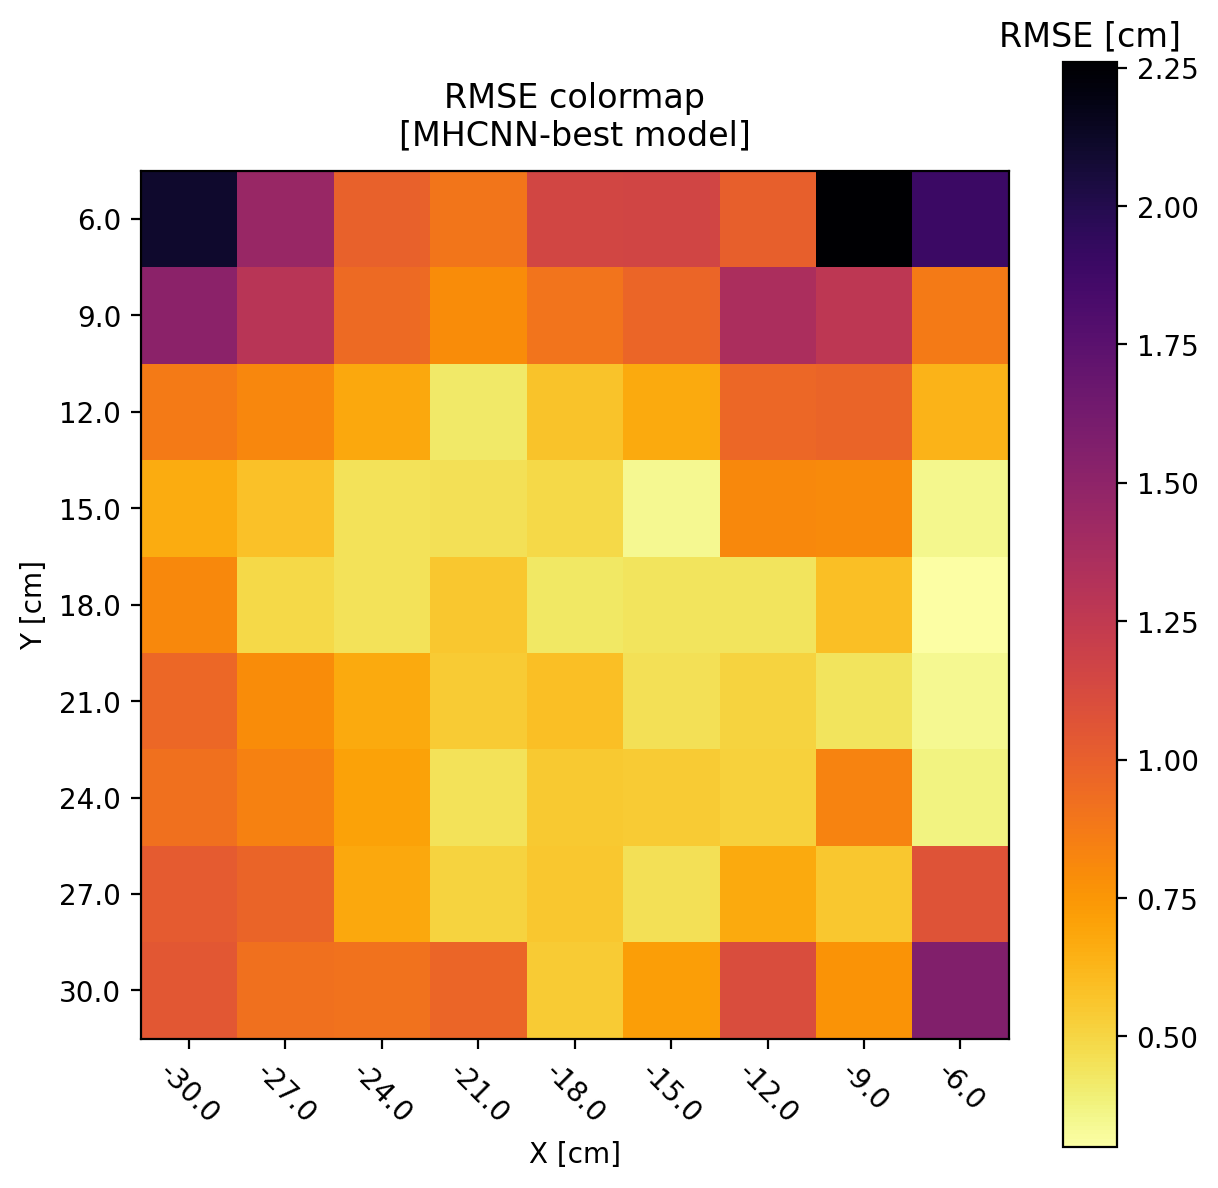

In [ ]:
import seaborn as sns
# define a function to plot the matrix
def plot_confusion_matrix(df_confusion, title='RMSE colormap\n[MHCNN-best model]', cmap=plt.cm.inferno_r):
  plt.matshow(df_confusion, cmap=cmap) # imshow
  plt.grid(False)
  plt.title(title, y=1.01)
  plt.colorbar().ax.set_title('RMSE [cm]')
  tick_marks = np.arange(len(df_confusion.columns))
  plt.xticks(tick_marks, df_confusion.columns, rotation=-45)
  plt.gca().xaxis.tick_bottom()
  plt.yticks(tick_marks, df_confusion.index)
  plt.ylabel(df_confusion.index.name)
  plt.xlabel(df_confusion.columns.name)

plot_confusion_matrix(conf_mat_cnn)#, cmap=plt.cm.bwr)
plt.savefig('/home/studio-lab-user/sagemaker-studiolab-notebooks/RETE/Plots/conf_matrix_cnn_best.png', dpi=300)
plt.savefig('/home/studio-lab-user/sagemaker-studiolab-notebooks/RETE/Plots/conf_matrix_cnn_best.pdf', dpi=300)

# Simulation

To simulate a signal seen by the PMTs, related to the passage of a particle in a certain position (x,y), a toy has been constructed. \\
Thereby it is also possible to test the network behaviour in a more continuous way.

## Toy Model Helper Functions

In [ ]:
from numpy import random
from scipy.stats import norm
def sim_pcle_event():
  '''
  Returns two variables, (x,y), both uniformly distributed between -30 and 30
  '''
  x = random.uniform(-30, 30)
  y = random.uniform(-30, 30)
  return x, y

def vect_sum(array):
  '''
  Returns the quadrature sum of the elements of a given 2D array
  '''
  return np.sqrt(array[0]**2 + array[1]**2)

def compute_relative_pos():
  '''
  Returns a dictionary containing the relative positions
  of the PMTs and a 2D vector containing the (x,y) position
  of the simulated event
  '''
  # define the fixed position of the PMTs
  PMT1_xy = np.array([30,30])
  PMT2_xy = np.array([30,-30])
  PMT3_xy = np.array([-30,-30])
  PMT4_xy = np.array([-30,30])

  # simulate an event
  pcle_xy = np.array(sim_pcle_event())

  # compute relative distances
  distances = {}
  distances['PMT1'] = PMT1_xy - pcle_xy
  distances['PMT2'] = PMT2_xy - pcle_xy
  distances['PMT3'] = PMT3_xy - pcle_xy
  distances['PMT4'] = PMT4_xy - pcle_xy

  return distances, pcle_xy

def additive_noise():
  '''
  Returns a Gaussian-distributed value
  '''
  return random.normal( loc=1, scale=0.5, size=(1024))

def simulate_event(batch_size=1, noisy=True, to_tensor=True, device='cpu', visualize=False):
  '''
  Args:
      batch_size: if specified, returns multiple events related to the
                  same particleposition (default=1)
      noisy: if True, a gaussian noise will be added to the
             simulated data (default=True)
      to_tensor: if True, it converts the simulated data to a
                 torch.Tensor instance (default=True)
      device: if specified, moves the output to the preferred
              computing device (default='cpu')
      visualize: if True, the setup configuration with the simulated
                 particle position will be displayed, along with the
                 corresponding PMT signals (default=False)

  Returns:
          a ndarray with shape (batch_size, 4, 1024) which contains 'batch_size'
          events with 4 channels (1 per PMT) and 1024 values per channel (the waveforms)
  '''
  # generate event and compute relative positions
  dist, pcle_pos = compute_relative_pos()

  # construct waveforms using the gaussian pdf and a correctly spaced time vector
  t = np.linspace(0,1024,1024)
  PMT_waveforms = 1e5*norm.pdf(t, loc=270, scale=25)

  noise=0

  # construct the event vector
  event=np.zeros(shape=(batch_size,4,1024))
  for j in range(batch_size):
    if noisy: noise=additive_noise()
    event[j] = np.asarray( [ noise + ( 1 / vect_sum( dist[f'PMT{i+1}'] ) )*PMT_waveforms for i in range(4) ] )

  # plot setup if requested
  if visualize:
    PMTs_loc = {'PMT1': np.array([30,30]),
                'PMT2': np.array([30,-30]),
                'PMT3': np.array([-30,-30]),
                'PMT4': np.array([-30,30])
                }
    show_setup(PMTs_loc, dist, pcle_pos, event)

  if not to_tensor:
    return event/event.max(), pcle_pos
  else:
    return torch.Tensor(event/event.max()).to(device), torch.Tensor(pcle_pos).to(device)

def show_setup(PMTs_loc, distances, pcle_pos, event):
  '''
  Help function to display the setup and waveform given the PMT positions,
  relative distances wrt the position of the particle and the vector
  containing the event(s)
  '''
  fig = plt.figure(figsize=(5,5), dpi=100)
  plt.title('Simulation Setup\n [green = event , blue = PMTs]')
  plt.xlabel('X [cm]')
  plt.ylabel('Y [cm]')
  for i in range(4):
    plt.plot(PMTs_loc[f'PMT{i+1}'][0], PMTs_loc[f'PMT{i+1}'][1], marker=f'${i+1}$', ms=25, mfc='blue', mec='blue')
  plt.plot(pcle_pos[0], pcle_pos[1], marker='*', ms=30, mfc='green', mec='green', label='simulated event')

  # plt.savefig('/content/drive/MyDrive/PhysLabII-Cygno/Rete/Simulation/setup.pdf')
  # plt.savefig('/content/drive/MyDrive/PhysLabII-Cygno/Rete/Simulation/setup.png')
  plot(-1*event[0], label=pcle_pos.round(1), run='simulated', trigger=False)

## Training over simulated data

Here the logic is the same as the one used for the real dataset, although there are some little adjustments, e.g. the fact that the events are generate loop-by-loop and not stored in a dataset which is accessed afterwards.

In [ ]:
def train_model_on_simulation(model, criterion, optimizer, metric_func, scheduler=None, num_epochs=25, tot_events=100, noise=True, device='cpu'):
  since = time.time()

  model.to(device)
  print('The model is now in the: ', next(model.parameters()).device)

  train_loss = []
  train_metric = []
  val_loss = []
  val_metric = []
  log_dict_epoch = {}
  log_dict_step = {}

  mb = master_bar(range(num_epochs))
  for epoch in mb:
    print(f'Epoch {epoch + 1}/{num_epochs} | current LR: {scheduler.get_last_lr()}')
    print('-' * 10)

    # Each epoch has a training and validation phase
    for phase in ['train', 'val']:
      if phase == 'train': model.train()  # Set model to training mode
      else: model.eval()   # Set model to evaluate mode

      running_loss = 0.0
      running_metric = 0.0

      counter = 0

      # Iterate over data
      for j in progress_bar(range(tot_events), parent=mb):
        input, label = simulate_event(noisy=noise, device=device)
        counter+=1
        # zero the parameter gradients
        optimizer.zero_grad()

        # forward
        # track history if only in train
        with torch.set_grad_enabled(phase == 'train'):
          preds = model(input[:])
          loss = criterion(preds, label[:].unsqueeze(0))
          metric = metric_func( preds, label[:].unsqueeze(0) )

          # backward + optimize only if in training phase
          if phase == 'train':
            loss.backward()
            optimizer.step()

        # statistics
        running_loss += loss.item()
        running_metric += metric.item()


      if (scheduler!=None) & (phase == 'train') & isinstance(model, MCH): scheduler.step()

      epoch_loss = running_loss / counter
      epoch_metric = running_metric / counter

      if phase == 'train':
        train_loss.append(epoch_loss)
        train_metric.append(epoch_metric)
      else:
        val_loss.append(epoch_loss)
        val_metric.append(epoch_metric)

      print(f'{phase} Loss: {epoch_loss:.4f} Metric: {epoch_metric:.4f}')

      # saving best model
      if phase == 'val':
        save_best_model(epoch_loss, epoch, model, optimizer, criterion, metric_func)

      # ✍️ Log validation metrics to W&B ✍️
      if LOG_TO_WANDB:
        if phase == 'train':
          # ✍️ Log your loss for this step to wandb ✍️
          log_dict_epoch[f'{phase}/loss'] = epoch_loss
          log_dict_epoch[f'{phase}/metric'] = epoch_metric

        if phase == 'val':
          log_dict_epoch[f'{phase}/loss'] = epoch_loss
          log_dict_epoch[f'{phase}/metric'] = epoch_metric
          wandb.log(log_dict_epoch)


    print()

  if LOG_TO_WANDB:
    wandb.run.summary["final_metric"] = epoch_metric
    wandb.run.summary["final_loss"] = epoch_loss
    wandb.run.finish()

  time_elapsed = time.time() - since
  print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')

  plot_info(train_loss, train_metric, val_loss, val_metric)
  return model


def plot_info(train_loss, train_metric, val_loss, val_metric):
  # Create figure and subplot
  fig, ax = plt.subplots(1,2)

  x = np.linspace(0, len(train_loss), len(train_loss));
  ax[0].plot(x, train_loss, label='train_loss')
  ax[0].plot(x, val_loss, label='val_loss')
  ax[0].legend()

  ax[1].plot(x, train_metric, label='train_metric')
  ax[1].plot(x, val_metric,  label='val_metric')
  ax[1].legend()

In [ ]:
# Hyperparams
LR = 0.001
num_epochs = 20
tot_events = 2000
noise = True
LOG_TO_WANDB=True
STEP_SIZE=15
GAMMA=0.1

# model selection
Select=2

if Select==1:
    model = Simple_MLP()
if Select==2:
    model = MCH(
                ksize1=49,
                ksize2=99,
                ksize3=199,
                num_layers=2,
                hid_channels=16
                )

# loss
loss_func = nn.MSELoss()
metric_func = nn.L1Loss()

# optimizer
from torch import optim
opt = optim.Adam(model.parameters(), lr=LR)
if isinstance(model, MCH): scheduler = StepLR(opt, step_size=STEP_SIZE, gamma=GAMMA)

# checkpoint function
save_best_model = SaveBestModel()

In [ ]:
if LOG_TO_WANDB:
  if isinstance(model, Simple_MLP):
    wandb.init(project=str(model.model_type)+'_simdata',
           config={
                  "loss_func": str(loss_func),
                  "metric": str(metric_func),
                  "optimizer": 'Adam',
                  "learning_rate": LR,
                  "epochs": num_epochs,
                  #"batch_size": BATCH_SIZE,
                  "events_per_iteration": tot_events,
                  "noise": str(noise)+'_scale05'
                  }
           )
  if isinstance(model, MCH):
    wandb.init(project=str(model.model_type)+'_simdata',
              config={
                      "loss_func": str(loss_func),
                      "metric": str(metric_func),
                      "optimizer": 'Adam',
                      "learning_rate": LR,
                      "epochs": num_epochs,
                      #"batch_size": BATCH_SIZE,
                      "events_per_iteration": tot_events,
                      "kernel_sizes": [model.ksize1, model.ksize2, model.ksize3],
                      "hidden layers": model.num_layers,
                      "hidden layer channels": model.hidden_channels,
                      "scheduler step, gamma": [scheduler.step_size, scheduler.gamma]
                      }
                )

  # Start tracking your model's gradients
  wandb.watch(model);


In [ ]:
model = train_model_on_simulation(model, loss_func, opt, metric_func, scheduler, num_epochs=num_epochs, tot_events=tot_events, noise=noise, device=device)

## Testing model on simulated data

In [ ]:
# load the best model checkpoint
best_model = torch.load('/content/drive/MyDrive/PhysLabII-Cygno/Rete/Checkpoints/best_model_simdata_gpu_nonoise.pth')#, map_location=torch.device('cpu'))
best_model_epoch = best_model['epoch']
print(f"Best model was saved at {best_model_epoch} epochs\n")

model_loaded = Simple_MLP()
model_loaded.load_state_dict(best_model['model_state_dict'])

Best model was saved at 44 epochs



<All keys matched successfully>

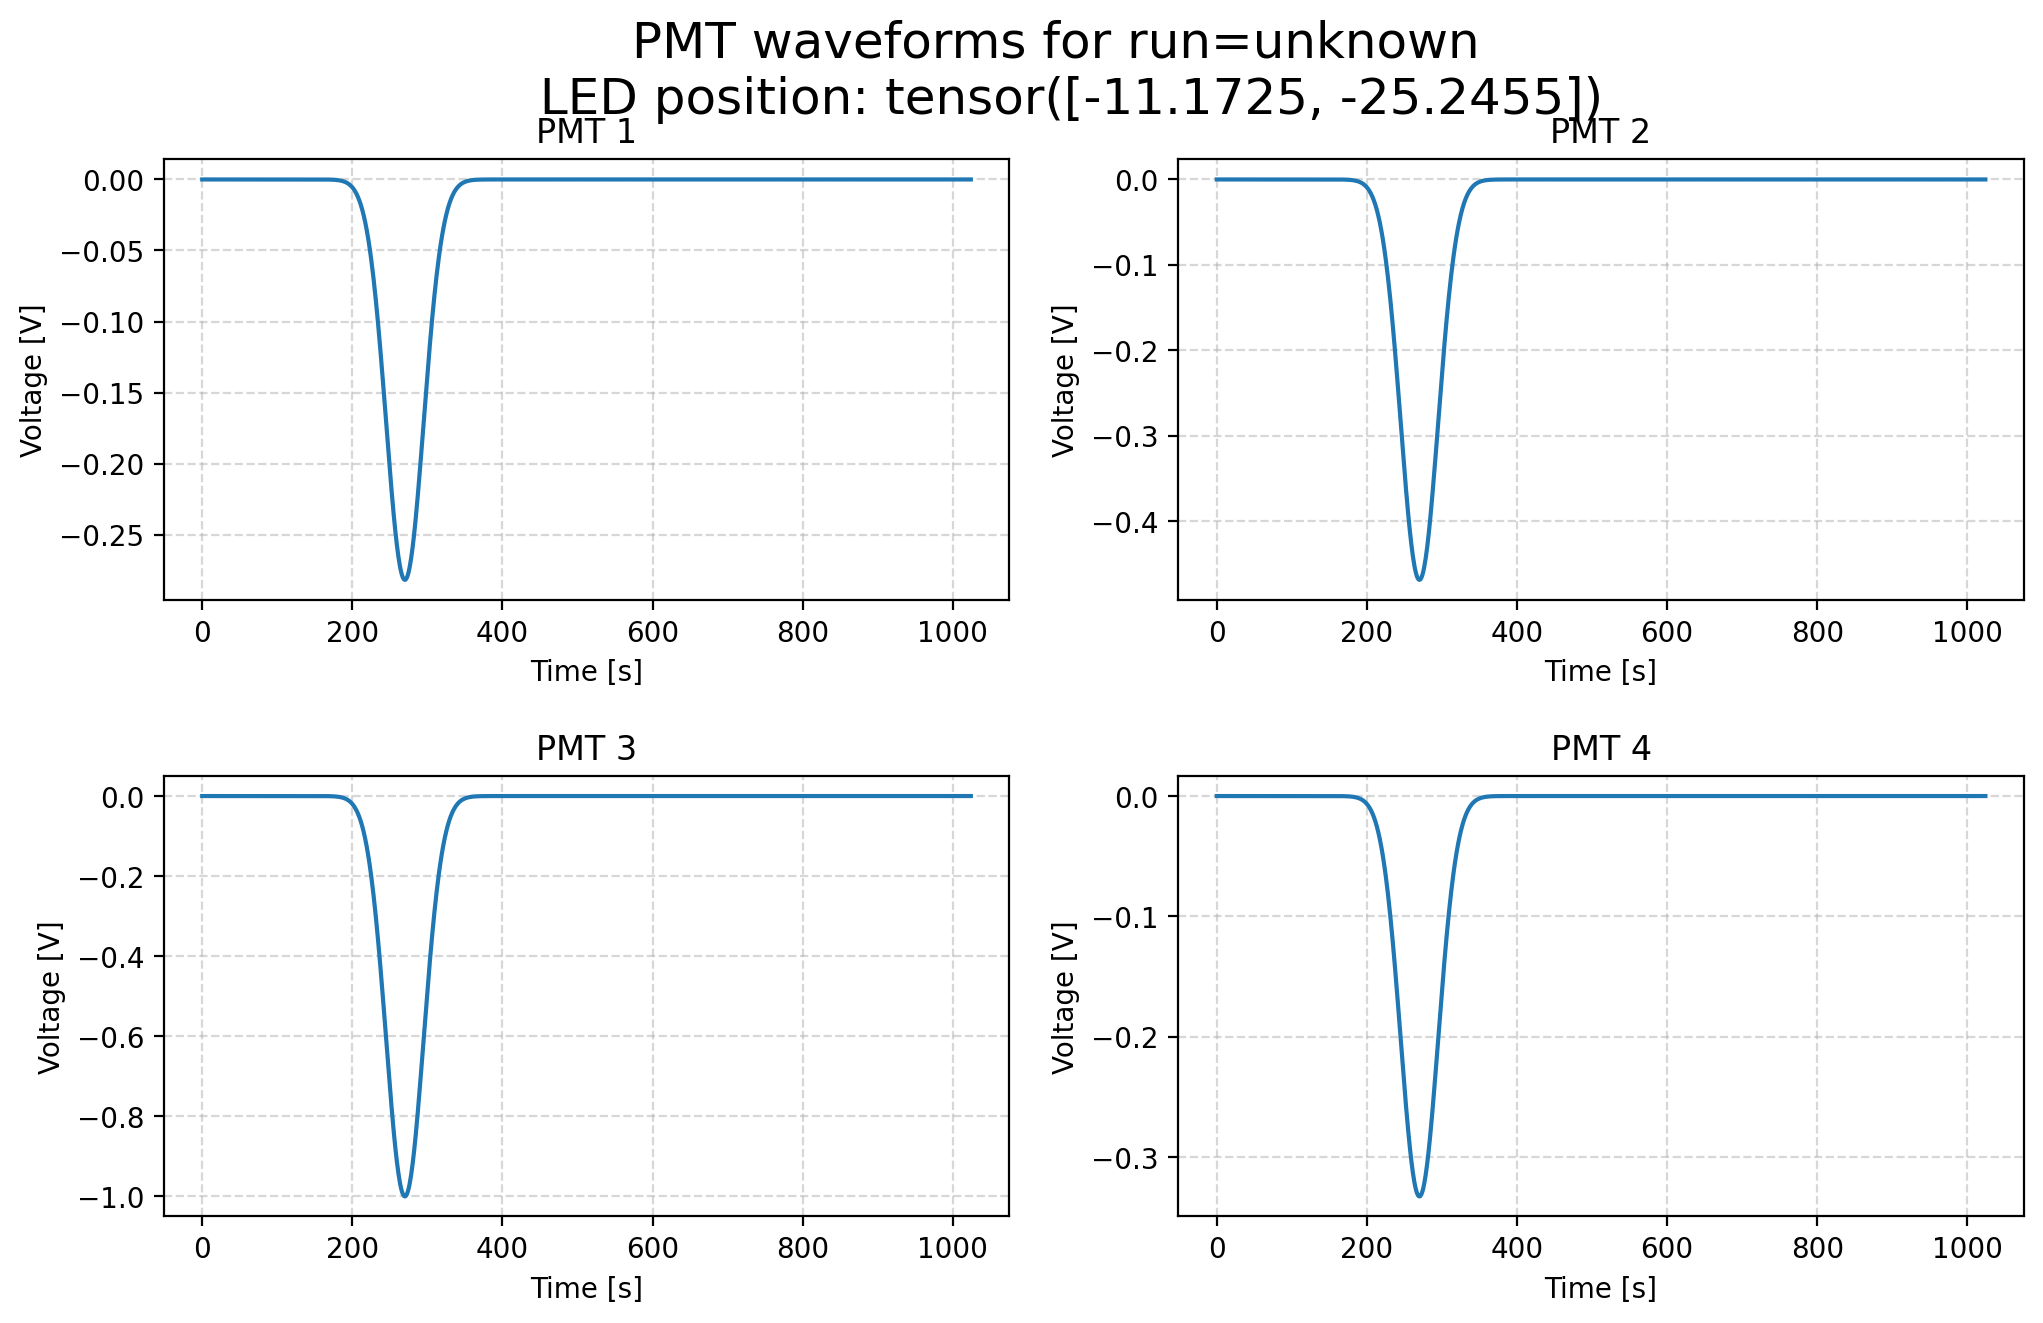

Prediction: [[-11.2  -25.95]]
Target: [-11.17 -25.25]
Loss: 0.2500609755516052


In [ ]:
model_loaded.eval()
loss_func = nn.MSELoss()
BS=1
event, target = simulate_event(batch_size=BS, noisy=False)
preds = model_loaded(event)
lost = loss_func(preds, torch.tile(target, (BS,1)))
plot(-1*event[0], label=target, trigger=False)

print(f'Prediction: {preds.detach().numpy().round(2)}')
print(f'Target: {target.cpu().numpy().round(2)}')
print(f'Loss: {lost}')

## Confusion Matrix

Notice that this time the mapping is almost continuous if the number of sample is sufficiently large. Nevertheless, if testing the MHCNN, it requires some time to run the following cell, also with an available GPU. \\
e.g. A Tesla T4 completes the task in almost 20 minutes with 10000 simulated events... 😱

In [ ]:
BS=32
df = pd.DataFrame()
with torch.no_grad():
  for _ in progress_bar(range(int(1e5))):
    event, target = simulate_event(batch_size=BS, noisy=False)
    preds = model_loaded(event)
    rmse = np.sqrt( loss_func(preds, torch.tile(target, (BS,1))).cpu().numpy() )
    df.loc[str(target[0].cpu().numpy().round(0)), str(target[1].cpu().numpy().round(0))] = rmse

df

,-29.0,7.0,-6.0,0.0,3.0,-11.0,12.0,-21.0,-17.0,-3.0,...,9.0,5.0,4.0,-9.0,-19.0,-18.0,10.0,-20.0,-22.0,26.0
-7.0,0.981267,0.145428,0.296984,0.566888,0.164996,0.499271,0.275498,0.943171,0.880535,0.459257,...,0.076724,0.187287,0.170502,0.348634,0.984453,1.027953,0.109606,1.038994,0.868907,0.741400
-24.0,1.893090,0.418408,0.732399,1.168010,0.396432,0.759530,0.739470,0.896031,0.578601,0.630172,...,0.636117,0.332088,0.327287,1.004717,0.747673,0.588249,0.702484,0.810801,0.942575,1.479545
2.0,0.412125,0.406120,0.369203,0.631244,0.178801,0.360579,0.553539,0.902492,0.407607,0.663689,...,0.493827,0.138459,0.057145,0.222337,0.635217,0.629073,0.598693,0.831368,0.943756,0.649715
-1.0,0.823920,0.062172,0.669460,0.149867,0.169468,0.849827,0.186689,1.174956,0.788532,0.495655,...,0.049810,0.226369,0.237604,0.704003,1.137213,0.901035,0.056190,1.122656,1.495610,0.208316
-2.0,0.728746,0.101722,0.607728,0.212082,0.224118,0.745826,0.238390,1.088421,0.685554,0.345155,...,0.038708,0.200602,0.266447,0.750466,0.743190,0.698644,0.091018,0.785871,1.086369,0.468231
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13.0,1.523331,0.217921,0.565582,0.468244,0.182862,0.695984,0.233632,0.584832,0.737758,0.031647,...,0.116514,0.177578,0.195716,0.660587,0.715707,0.776808,0.327033,0.617864,0.533066,0.640996
-21.0,1.865021,0.354355,0.811614,0.748095,0.191188,0.793704,0.748260,1.012264,0.731620,0.534307,...,0.636080,0.204311,0.201173,0.973736,0.882435,0.822417,0.652719,0.951790,1.010183,1.781065
30.0,1.431101,1.644771,1.311531,0.700055,0.917506,1.132388,1.069932,1.729599,1.161819,0.751702,...,1.632042,1.395939,1.187161,1.126933,1.536365,1.172152,1.366124,1.485624,1.582369,4.086821
-6.0,0.875755,0.022486,0.381866,0.484765,0.164975,0.500522,0.325054,0.908238,0.798487,0.452516,...,0.109076,0.247511,0.207403,0.438666,0.976019,0.869153,0.191538,0.941436,0.856923,0.890384


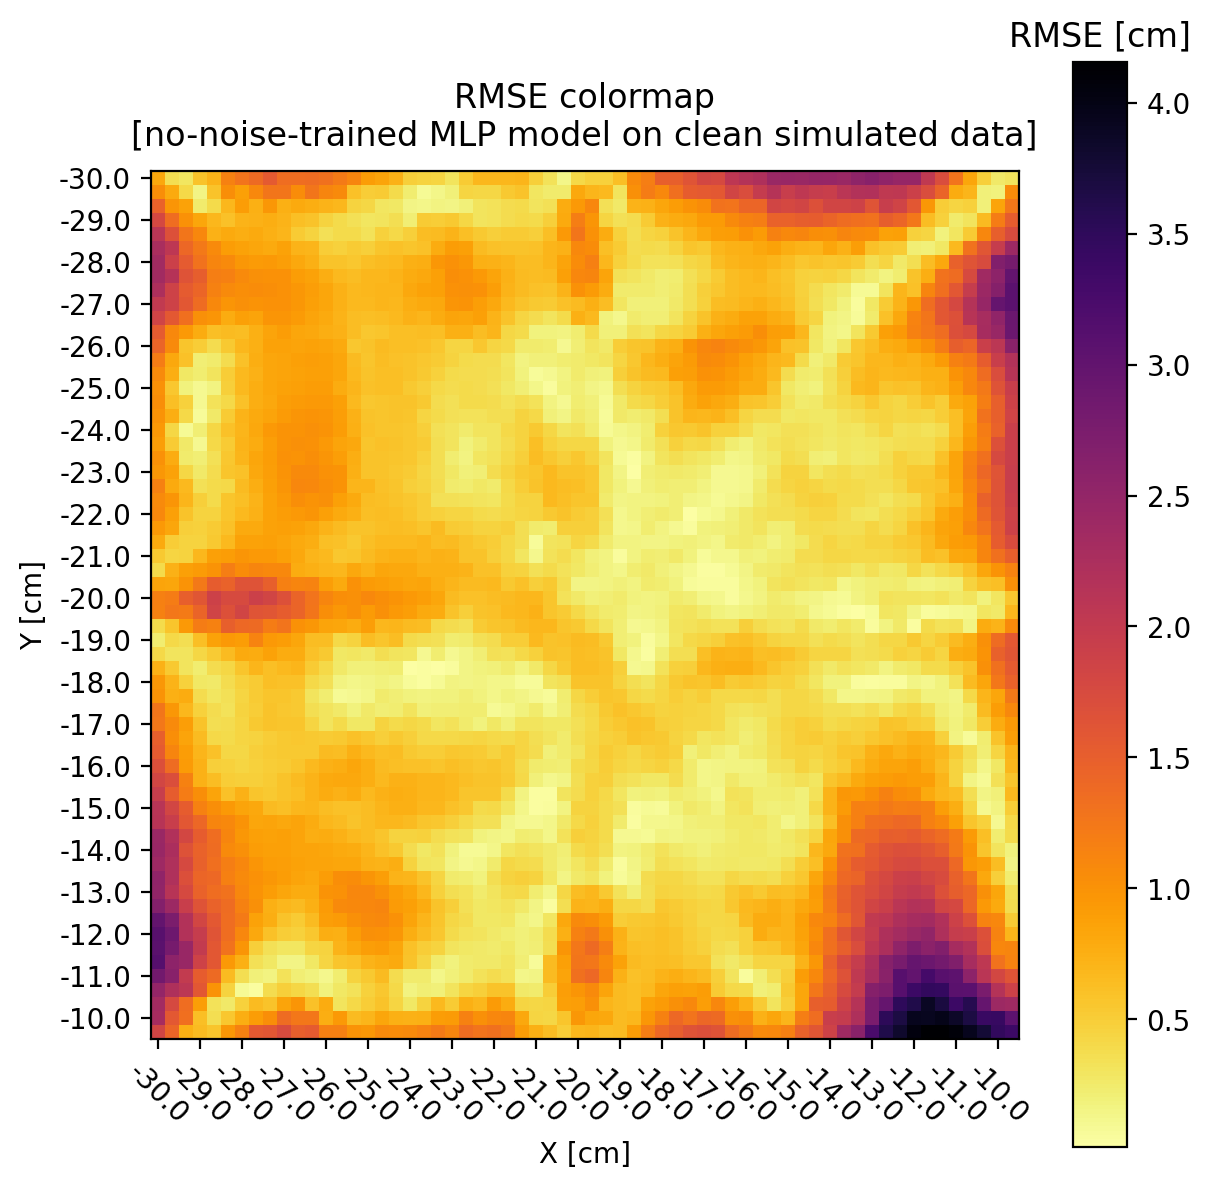

In [ ]:
import seaborn as sns
def plot_confusion_matrix(df_confusion, title='RMSE colormap\n[no-noise-trained MLP model on clean simulated data]', cmap=plt.cm.inferno_r):
  corr_index = [str(string) for string in np.sort([float(x) for x in df.columns])]
  X = np.sort(np.asarray([float(x) for x in df.columns]))
  Y = np.sort(np.asarray([float(y) for y in df.index]))
  sorted_df = df_confusion.reindex(columns=corr_index, index=corr_index)
  plt.matshow(sorted_df, cmap=cmap) # imshow
  plt.title(title, y=1.01)
  plt.colorbar().ax.set_title('RMSE [cm]')
  plt.grid(False)

  tick_marks_x = np.arange(len(sorted_df.columns), step=3)
  tick_marks_y = np.arange(len(sorted_df.index), step=3)
  plt.xticks(tick_marks_x, sorted_df.columns, rotation=-45)
  plt.gca().xaxis.tick_bottom()
  plt.yticks(tick_marks_y, sorted_df.index)

  plt.ylabel('Y [cm]')
  plt.xlabel('X [cm]')

plot_confusion_matrix(df)
# plt.savefig('/content/drive/MyDrive/PhysLabII-Cygno/Rete/Plots/Sim/conf_matrix_simdata_nonoise_on_clean.pdf', dpi=300)
# plt.savefig('/content/drive/MyDrive/PhysLabII-Cygno/Rete/Plots/Sim/conf_matrix_simdata_nonoise_on_clean.png', dpi=300)